In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install patchify

In [3]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from patchify import patchify, unpatchify
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout
from keras.utils import to_categorical, normalize
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.metrics import MeanIoU, IoU
import datetime

In [4]:
# Set random seed
tf.random.set_seed(42)

In [5]:
# Define the model
def simple_res_unet_model(img_width, img_height, img_channels):
    # Build the model
    inputs = Input((img_width, img_height, img_channels))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    c6 = concatenate([c6, c4])  # Residual connection

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    c7 = concatenate([c7, c3])  # Residual connection

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    c8 = concatenate([c8, c2])  # Residual connection

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    c9 = concatenate([c9, c1])  # Residual connection

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # model.summary()

    return model

In [6]:
# Create an instance of the model
model = simple_res_unet_model(256,256,1)

In [7]:
# Directories
base_dir = '/content/drive/MyDrive/TCC_FACENS'
image_directory = base_dir + '/dataset/1'
mask_directory = base_dir + '/dataset/2'

In [8]:
# # Read Image files
# images = os.listdir(image_directory)
# sorted_images = sorted(images)

# image_dataset = []
# for i, image_name in enumerate(sorted_images):
#     if image_name.lower().endswith(('.tif')):
#         image_path = os.path.join(image_directory, image_name)
#         try:
#             image = Image.open(image_path)
#             image = image.convert('L')
#             image_array = np.array(image)
#             image_dataset.append(image_array)
#         except Exception as e:
#             print(f"Error reading image {image_path}: {e}")


# # Read Mask files
# masks = os.listdir(mask_directory)
# sorted_masks = sorted(masks)

# mask_dataset = []
# for i, mask_name in enumerate(sorted_masks):
#     if mask_name.lower().endswith(('.tif')):
#         mask_path = os.path.join(mask_directory, mask_name)
#         try:
#             mask = Image.open(mask_path)
#             mask_array = np.array(mask)
#             mask_dataset.append(mask_array)
#         except Exception as e:
#             print(f"Error reading image {mask_path}: {e}")

# #Normalize images
# image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),axis=3)

# #Do not normalize masks, just rescale to 0 to 1.
# mask_dataset = np.expand_dims((np.array(mask_dataset)), 3)

# # Save image and mask datasets
# np.save( base_dir + '/notebooks/dataset_input/image_dataset_single.npy', image_dataset)
# np.save( base_dir + '/notebooks/dataset_input/mask_dataset_single.npy', mask_dataset)

In [9]:
# Load image and mask datasets
image_dataset = np.load( base_dir + '/notebooks/dataset_input/image_dataset_single_pre.npy')
mask_dataset = np.load( base_dir + '/notebooks/dataset_input/mask_dataset_single.npy')

In [10]:
# #Sanity check, view few mages
# image_number = random.randint(0, len(image_dataset))
# plt.figure(figsize=(10, 5))
# plt.subplot(121)
# plt.imshow(np.reshape(image_dataset[image_number], (256, 256)), cmap='gray')
# plt.subplot(122)
# plt.imshow(np.reshape(mask_dataset[image_number], (256, 256)), cmap='gray')
# plt.show()

In [11]:
# Split train and test
X_train, X_test, y_train, y_test = train_test_split(image_dataset,
                                                    mask_dataset,
                                                    test_size = 0.2,
                                                    random_state = 42)

In [12]:
# # Rebalancing dataset
# class_weights = class_weight.compute_class_weight(class_weight ='balanced', classes= np.unique(mask_dataset), y= mask_dataset.flatten())
# class_weights_dict = dict(zip(np.unique(mask_dataset), class_weights))
# print(class_weights_dict)

class_weights_dict = {0: 2.951776802693238, 1: 0.601966867345094}

In [13]:
# Define Model
model = simple_res_unet_model(256, 256, 1)

In [14]:
# Training Parameters
batch_input = 30
epoch_input = 40

# Definindo o Early Stopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10, verbose=1,
                           restore_best_weights=True)

# Define the learning rate schedule function
def lr_schedule(epoch, lr):
    total_iterations = len(X_train) // batch_input * epoch_input
    return lr * (1 - epoch / epoch_input) ** 0.9

# Create the LearningRateScheduler callback
lr_ajust = LearningRateScheduler(lr_schedule)

In [15]:
start2 = datetime.datetime.now()

# Train the model
history = model.fit(X_train, y_train,
                    batch_size = batch_input,
                    verbose=1,
                    epochs= epoch_input,
                    validation_data= (X_test, y_test),
                    class_weight= class_weights_dict,
                    shuffle=False,
                    callbacks=[early_stop, lr_ajust])

stop2 = datetime.datetime.now()


Epoch 1/40
39/39 [==============================] - 59s 696ms/step - loss: 0.5587 - accuracy: 0.8003 - val_loss: 0.4886 - val_accuracy: 0.8132 - lr: 0.0010
Epoch 2/40
39/39 [==============================] - 16s 404ms/step - loss: 0.4338 - accuracy: 0.8082 - val_loss: 0.4316 - val_accuracy: 0.8272 - lr: 9.7747e-04
Epoch 3/40
39/39 [==============================] - 17s 426ms/step - loss: 0.4166 - accuracy: 0.8190 - val_loss: 0.3825 - val_accuracy: 0.8548 - lr: 9.3337e-04
Epoch 4/40
39/39 [==============================] - 17s 427ms/step - loss: 0.4038 - accuracy: 0.8275 - val_loss: 0.3677 - val_accuracy: 0.8564 - lr: 8.7013e-04
Epoch 5/40
39/39 [==============================] - 16s 405ms/step - loss: 0.3893 - accuracy: 0.8340 - val_loss: 0.3311 - val_accuracy: 0.8697 - lr: 7.9141e-04
Epoch 6/40
39/39 [==============================] - 16s 420ms/step - loss: 0.3643 - accuracy: 0.8443 - val_loss: 0.3582 - val_accuracy: 0.8491 - lr: 7.0179e-04
Epoch 7/40
39/39 [==========================

In [16]:
#Execution time of the model
execution_time = stop2-start2
print("Execution time is: ", execution_time)

# Execution time is:  0:07:04.480228

Execution time is:  0:06:57.620817


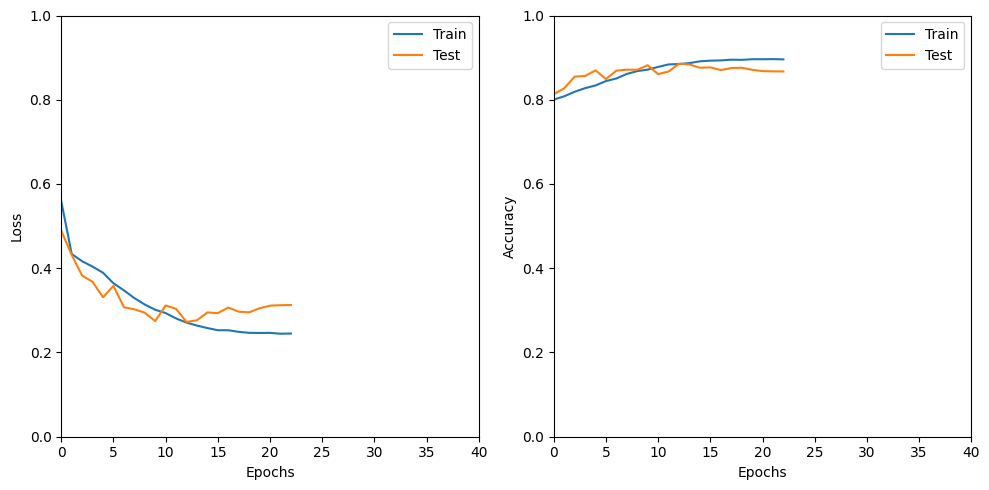

In [17]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot training & validation loss values
axes[0].plot(history.history['loss'], label='Train')
axes[0].plot(history.history['val_loss'], label='Test')
# axes[0].set_title('Curva de Perda')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_ylim([0, 1])
axes[0].set_xlim([0, 40])

# Plot training & validation accuracy values
axes[1].plot(history.history['accuracy'], label='Train')
axes[1].plot(history.history['val_accuracy'], label='Test')
# axes[1].set_title('Curva de Acurácia')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_ylim([0, 1])
axes[1].set_xlim([0, 40])

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [18]:
# Save the model
model.save( base_dir + '/notebooks/models/single_unet_2_pre.keras')

In [19]:
# Load the weights
model.load_weights( base_dir + '/notebooks/models/single_unet_2_pre.keras')

In [20]:
# Running Prediction
y_pred = model.predict(X_test)

10/10 [==============================] - 6s 171ms/step


In [21]:
# Threshold
threshold = 0.5

y_pred_binary = (y_pred >= threshold).astype(int)
# Assuming you have one class
y_pred_argmax = y_pred_binary[:,:,:,0]

In [22]:
# Calculate the Overall IoU
# Set num_classes to 2 for binary classification (class and background)
IOU_keras = MeanIoU(num_classes=2)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

# Mean IoU = 0.7459089

Mean IoU = 0.71341145


In [23]:
# Assuming you have two classes: background (0) and the single class of interest (1)
iou_1 = IoU(num_classes=2, target_class_ids=[1])
iou_0 = IoU(num_classes=2, target_class_ids=[0])

# Update the state with ground truth and predicted labels for the foreground class
iou_1.update_state(y_test[:,:,:,0], y_pred_argmax)
iou_0.update_state(y_test[:,:,:,0], y_pred_argmax)

# Calculate the IoU for the foreground class
print("IoU Inside Grains (foreground) =", iou_1.result().numpy())
print("IoU Outside Grains (background) =", iou_0.result().numpy())

# IoU Inside Grains (foreground) = 0.89008147
# IoU Outside Grains (background) = 0.60173637

IoU Inside Grains (foreground) = 0.86595696
IoU Outside Grains (background) = 0.56086594


1/1 [==============================] - 1s 1s/step


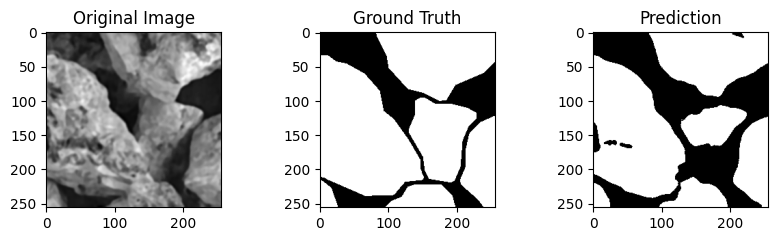

In [24]:
# Plot Patch comparison
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth = y_test[test_img_number]
test_img_norm = test_img[:, :, 0][:, :, None]
test_img_input = np.expand_dims(test_img_norm, 0)
prediction = model.predict(test_img_input)
# Thresholding at 0.5 for binary classification
prediction_img = (prediction >= 0.5).astype(int)[0, :, :, 0]

# Create the plot
plt.figure(figsize=(10, 5))
plt.subplot(231)
plt.title('Original Image')
plt.imshow(test_img[:, :, 0], cmap='gray')
plt.subplot(232)
plt.title('Ground Truth')
plt.imshow(ground_truth[:, :, 0], cmap='gray')
plt.subplot(233)
plt.title('Prediction')
plt.imshow(prediction_img, cmap='gray')
plt.show()

In [25]:
# Directory large images
base_dir = '/content/drive/MyDrive/TCC_FACENS'
large_path = base_dir + '/dataset/i_crop/conta04.tif'
mask_large_path = base_dir + '/dataset/m_crop_improved/conta04.tif'

In [26]:
# Read Large files and pathify image file
large_image = cv2.imread(large_path,0)
patches = patchify(large_image, (256,256), step=256)
large_mask = cv2.imread(mask_large_path,0)

In [27]:
# Predict a large image divided by patches
predict_patches = []
for i in range(patches.shape[0]):
  for j in range(patches.shape[1]):
    print(i,j)

    patch = patches[i,j,:,:]
    patch_norm = np.expand_dims(normalize(np.array(patch), axis=1), 2)
    patch_input = np.expand_dims(patch_norm, 0)
    patch_pred = (model.predict(patch_input))
    patch_pred_img = (patch_pred >= 0.5).astype(int)[0, :, :, 0]
    predict_patches.append(patch_pred_img)

0 0
1/1 [==============================] - 0s 19ms/step
0 1
1/1 [==============================] - 0s 18ms/step
0 2
1/1 [==============================] - 0s 17ms/step
0 3
1/1 [==============================] - 0s 21ms/step
0 4
1/1 [==============================] - 0s 18ms/step
1 0
1/1 [==============================] - 0s 17ms/step
1 1
1/1 [==============================] - 0s 19ms/step
1 2
1/1 [==============================] - 0s 18ms/step
1 3
1/1 [==============================] - 0s 17ms/step
1 4
1/1 [==============================] - 0s 18ms/step
2 0
1/1 [==============================] - 0s 24ms/step
2 1
1/1 [==============================] - 0s 18ms/step
2 2
1/1 [==============================] - 0s 17ms/step
2 3
1/1 [==============================] - 0s 18ms/step
2 4
1/1 [==============================] - 0s 18ms/step
3 0
1/1 [==============================] - 0s 21ms/step
3 1
1/1 [==============================] - 0s 24ms/step
3 2
1/1 [==============================] - 0s 21

In [28]:
# Unpathify large image
predict_patches = np.array(predict_patches)
predict_patches_reshape = np.reshape(predict_patches, (patches.shape[0], patches.shape[1], 256, 256))
unpatched_image = unpatchify(predict_patches_reshape, large_image.shape)

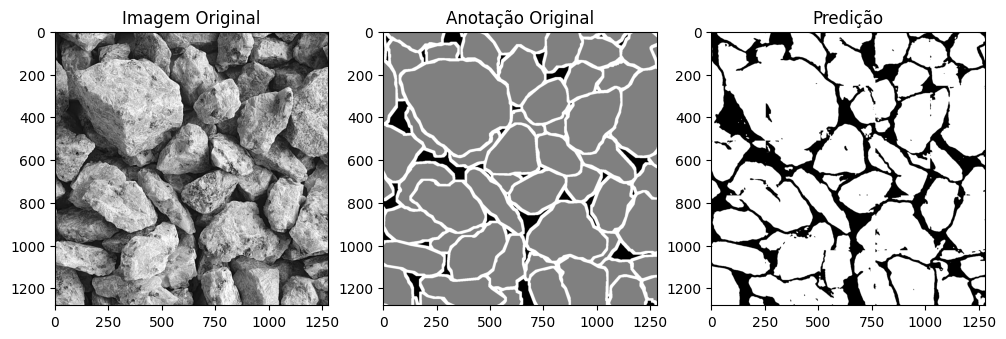

In [29]:
# Plot comparison
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Imagem Original')
plt.imshow(large_image, cmap='gray')
plt.subplot(232)
plt.title('Anotação Original')
plt.imshow(large_mask, cmap='gray')
plt.subplot(233)
plt.title('Predição')
plt.imshow(unpatched_image, cmap='gray')
plt.show()